<a href="https://colab.research.google.com/github/RhysWangJunfei/nilm/blob/master/nilm_dwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import io
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from google.colab import files

In [0]:
'''Sliding window function'''
def create_dataset(dataset, look_back=1):
    dataX = []
    for i in range(len(dataset)-look_back+1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
    return np.array(dataX)

In [6]:
#uploaded = files.upload()
'''Load data'''
WHE_data = pd.read_csv('Electricity_WHE.csv')['P']
#WHE_data = pd.read_csv(io.BytesIO(uploaded['Electricity_WHE.csv']))['P']
#uploaded = files.upload()
#DWE_data = pd.read_csv(io.BytesIO(uploaded['Electricity_DWE.csv']))['P']
DWE_data = pd.read_csv('Electricity_DWE.csv')['P']
'''
CDE_data = pd.read_csv(base_dir+'Electricity_CDE.csv')['P']
CWE_data = pd.read_csv(base_dir+'Electricity_CWE.csv')['P']
DWE_data = pd.read_csv(base_dir+'Electricity_DWE.csv')['P']
FRE_data = pd.read_csv(base_dir+'Electricity_FRE.csv')['P']
HPE_data = pd.read_csv(base_dir+'Electricity_HPE.csv')['P']
HTE_data = pd.read_csv(base_dir+'Electricity_HTE.csv')['P']
'''

"\nCDE_data = pd.read_csv(base_dir+'Electricity_CDE.csv')['P']\nCWE_data = pd.read_csv(base_dir+'Electricity_CWE.csv')['P']\nDWE_data = pd.read_csv(base_dir+'Electricity_DWE.csv')['P']\nFRE_data = pd.read_csv(base_dir+'Electricity_FRE.csv')['P']\nHPE_data = pd.read_csv(base_dir+'Electricity_HPE.csv')['P']\nHTE_data = pd.read_csv(base_dir+'Electricity_HTE.csv')['P']\n"

In [0]:
window_size=60

dataX = create_dataset(WHE_data.as_matrix(), window_size)

#1-25,110-180,720-840,others

dwe_Y = DWE_data[window_size-1:].values.reshape([DWE_data.shape[0]-window_size+1,1])
categorized_dwe_Y = np.zeros(dwe_Y.shape)
categorized_dwe_Y[[np.where((dwe_Y>0)&(dwe_Y<=25))[0]],:]=1
categorized_dwe_Y[[np.where((dwe_Y>110)&(dwe_Y<=180))[0]],:]=2
categorized_dwe_Y[[np.where((dwe_Y>720)&(dwe_Y<=840))[0]],:]=3
categorized_dwe_Y[[np.where(((dwe_Y>25)&(dwe_Y<110))|((dwe_Y>180)&(dwe_Y<720))|((dwe_Y>840)))[0]],:]=4

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


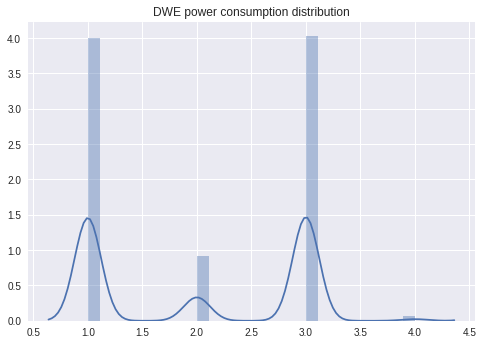

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(categorized_dwe_Y[categorized_dwe_Y>0])
plt.title('DWE power consumption distribution')
plt.show()

In [0]:
dweY=categorized_dwe_Y[categorized_dwe_Y>0].reshape(-1,1)
dweX=dataX[[np.where(categorized_dwe_Y>0)[0]],:][0]

encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
dweY_1hot = encoder.fit_transform(dweY)

X_train, X_test, y_train, y_test = train_test_split(dweX, dweY_1hot, test_size=0.1, shuffle=True)
scaler = MinMaxScaler()
scaler.fit(X_train.astype(float))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
'''Hyper parameters for deep learning'''
# Hyper Parameters
LR = 0.001               # learning rate
#cfg_list = nf.model_configs()
#error_list = []

#hyperparameters
batch_size=512
unit_num=128

In [11]:
'''RNN Model Definition'''
#define inputs
tf_x = tf.placeholder(tf.float32, [None, window_size,1])
tf_y = tf.placeholder(tf.int32, [None, 4])
#Transform from 3d to 2d
#X = tf.reshape(tf_x, [-1, 1])
#X = tf.reshape(tf_x, [-1, window_size])


'''
add_layer('l1',X,window_size, 128, activation_function=tf.nn.sigmoid)
l2 = add_layer('l2',l1, 128,32 , activation_function=tf.nn.sigmoid)
l3 = add_layer('l3',l2, 32,8 , activation_function=tf.nn.sigmoid)
pred = add_layer('l4',l3, 8,1 , activation_function=None)
'''
#X_in = tf.reshape(tf_x, [-1, 1])
lstm_cell =tf.contrib.rnn.BasicLSTMCell(num_units=unit_num)
outputs, (h_c, h_n) = tf.nn.dynamic_rnn(
    lstm_cell,                   # cell you have chosen
    tf_x,                      # input
    initial_state=None,         # the initial hidden state
    dtype=tf.float32,           # must given if set initial_state = None
    time_major=False,           # False: (batch, time step, input); True: (time step, batch, input)
)
l1 = tf.layers.dense(outputs[:, -1, :],64,activation=tf.nn.leaky_relu)
l2 = tf.layers.dense(l1,32,activation=tf.nn.leaky_relu)
l3 = tf.layers.dense(l2,16,activation=tf.nn.leaky_relu)
#l4 = tf.layers.dense(l3,8,activation=tf.nn.leaky_relu)
#l5 = tf.layers.dense(l4,4,activation=tf.nn.leaky_relu)
#l6 = tf.layers.dense(l5,32,activation=tf.nn.leaky_relu)
#l7 = tf.layers.dense(l2,8,activation=tf.nn.leaky_relu)
pred = tf.layers.dense(l3,4,activation=tf.nn.relu)
#pred = add_layer('dense_1',outputs[:, -1, :], unit_num, 1, activation_function=tf.nn.leaky_relu)
'''
#dense_2 = add_layer('dense_2',dense_1, 32, 16, activation_function=tf.nn.leaky_relu)
#dense_3 = add_layer('dense_3',dense_2, 16, 4, activation_function=tf.nn.leaky_relu)
#dense_4 = add_layer('dense_4',dense_1, 1024, 512, activation_function=tf.nn.relu)
#dense_5 = add_layer('dense_5',dense_4, 512, 256, activation_function=tf.nn.relu)
#dense_6 = add_layer('dense_6',dense_5, 256, 128, activation_function=tf.nn.relu)
#dense_7 = add_layer('dense_7',dense_1, 128, 64, activation_function=tf.nn.relu)
#dense_8 = add_layer('dense_8',dense_7, 64, 16, activation_function=tf.nn.relu)
#dense_9 = add_layer('dense_9',dense_1, 8, 4, activation_function=tf.nn.relu)
#pred = add_layer('output', dense_3,4, 1, activation_function=None)
'''
with tf.name_scope('loss'):
    cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_y, logits=pred) 
    loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar("loss",tensor=loss)

train_op = tf.train.AdamOptimizer(LR).minimize(loss)

accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(pred, axis=1),)[1]

'''
gvs = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs) 
'''
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) 
sess = tf.Session()
sess.run(init_op)
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter("logss/", sess.graph) # tensorflow >=0.12
saver = tf.train.Saver()

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [0]:
batch_num = len(X_train)//batch_size
flag = False
for j in range(0,5000):
    print('###epoch: '+str(j)+'###')
    for i in range(0,batch_num+1):
        if(i!=batch_num):
            batch_X = X_train[i*batch_size:(i+1)*batch_size,].reshape([batch_size,window_size,1])
            batch_Y = y_train[i*batch_size:(i+1)*batch_size,]
        else: 
            batch_X = X_train[-batch_size:].reshape([batch_size,window_size,1])
            batch_Y = y_train[-batch_size:,]
        sess.run(train_op,{tf_x:batch_X,tf_y:batch_Y})
        cost_ = sess.run(loss, {tf_x: batch_X, tf_y:batch_Y})
        acc_train = sess.run(accuracy,{tf_x: batch_X, tf_y:batch_Y})
        acc_test = sess.run(accuracy,feed_dict={tf_x: X_test.reshape([X_test.shape[0],window_size,1]), tf_y:y_test})
        if i%10 == 0:
            rs = sess.run(merged,feed_dict={tf_x: batch_X, tf_y:batch_Y})
            pre = sess.run(pred,feed_dict={tf_x: batch_X, tf_y:batch_Y})
            writer.add_summary(rs, i+j*batch_num)
            y_lables_argmax = tf.argmax(tf_y,axis=1)  
            y_pred_argmax = tf.argmax(pre,axis=1)
            print('###Batch: '+str(i)+': train loss= %.4f' % cost_+', Acc=%.2f'% acc_train)
            print('Test Acc=%.2f'% acc_test)
            if acc_train>=0.97:
              print(j)
              save_path = saver.save(sess, "my_net/save_net_rnn_dwe.ckpt")
              flag = True
              break
    if(flag==True):
        print(flag)
        break
sess.close()


###epoch: 0###
###Batch: 0: train loss= 1.3845, Acc=0.12
Test Acc=0.10
###Batch: 10: train loss= 1.1536, Acc=0.41
Test Acc=0.41
###Batch: 20: train loss= 1.0773, Acc=0.43
Test Acc=0.43
###Batch: 30: train loss= 1.0210, Acc=0.43
Test Acc=0.43
###Batch: 40: train loss= 0.9814, Acc=0.44
Test Acc=0.44
###Batch: 50: train loss= 1.0427, Acc=0.44
Test Acc=0.44
###Batch: 60: train loss= 1.0392, Acc=0.44
Test Acc=0.44
###Batch: 70: train loss= 1.0004, Acc=0.45
Test Acc=0.45
###epoch: 1###
###Batch: 0: train loss= 1.0545, Acc=0.45
Test Acc=0.45
###Batch: 10: train loss= 1.0729, Acc=0.45
Test Acc=0.45
###Batch: 20: train loss= 1.0622, Acc=0.45
Test Acc=0.45
###Batch: 30: train loss= 0.9776, Acc=0.45
Test Acc=0.45
###Batch: 40: train loss= 0.9474, Acc=0.45
Test Acc=0.45
###Batch: 50: train loss= 0.9805, Acc=0.45
Test Acc=0.45
###Batch: 60: train loss= 0.9746, Acc=0.45
Test Acc=0.45
###Batch: 70: train loss= 0.9552, Acc=0.45
Test Acc=0.45
###epoch: 2###
###Batch: 0: train loss= 0.9789, Acc=0.45
Tes